In [10]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd
import seaborn as sns
from keras.utils.np_utils import to_categorical
import pywt

In [18]:
# for additional feature engineering 
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [13]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape


((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [14]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape


((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [31]:
model1 = load_model('transformer_price_volume_noiseAug_epoch_009_val_1.125.h5', custom_objects = {'Time2Vector':Time2Vector}) 


In [33]:

model2 = load_model('transformer_price_volume_epoch_017_val_0.988.h5', custom_objects = {'Time2Vector':Time2Vector}) 


In [25]:
model3 = load_model('attention_price_volume_epoch_002_val_0.980.h5', custom_objects = {'Time2Vector':Time2Vector})


In [22]:
seq_len=1500
N = 30
K = 120 
features_price = 4 
features_volume = 5

X_test_price = [] 
X_test_volume = []

for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-K-N-120, seq_len-K-N):
        X_test_price.append(x_test[j, i:i+N, [1,2,3,4]])  
        X_test_volume.append(x_test[j, i:i+N, [5,6,7,8,9]])

X_test_price = np.asarray(X_test_price) 
X_test_volume = np.asarray(X_test_volume) 

X_test_price = X_test_price.reshape((-1,N,features_price)) 
X_test_volume = X_test_volume.reshape((-1,N,features_volume))

X_test_price.shape, X_test_volume.shape


100%|██████████| 535/535 [00:00<00:00, 793.00it/s]


((64200, 30, 4), (64200, 30, 5))

In [35]:
pred1 = model1.predict([X_test_price, X_test_volume]).reshape((-1,120)) 


In [36]:
pred2 = model2.predict([X_test_price, X_test_volume]).reshape((-1,120)) 

In [37]:
pred3 = model3.predict([X_test_price, X_test_volume]).reshape((-1,120)) 

In [38]:
pred1.shape, pred2.shape, pred3.shape 

((535, 120), (535, 120), (535, 120))

In [39]:
# take the maximum predictions for each predictions 

preds = np.zeros((535,120)) 

for i in tqdm(range(535)): 
    for j in range(120): 
        preds[i,j] = max(pred1[i,j],pred2[i,j],pred3[i,j]) 

100%|██████████| 535/535 [00:00<00:00, 6766.33it/s]


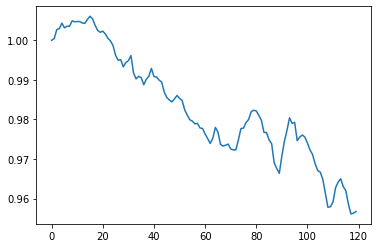

In [52]:
plt.plot(preds[3])

In [43]:
# adjust prices 

x_test_open = x_test[:,:,1] 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(preds.shape[0]), position = 0, leave = True):
    buy_price = x_test_open[i,-1] 
    if preds[i,0] > buy_price:
        diff = preds[i,0] - buy_price 
        preds[i,:] -= diff 
    elif preds[i,0] < buy_price:  
        diff = buy_price - preds[i,0] 
        preds[i,:] += diff


100%|██████████| 535/535 [00:00<00:00, 187386.44it/s]


In [49]:
# create dataframe using bullish then all in 

buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(preds.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(preds[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1]  
    ma = np.mean(x_test_open[i,-10:]) 
    cnt = 0 
    for j in range(120): 
        if preds[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = max((ma>buy_price)*1,cnt/120) 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('max_bullish_ensemble.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 13059.07it/s]


In [50]:
submission

,sample_id,buy_quantity,sell_time
0,7661,1.000000,104
1,7662,0.941667,54
2,7663,1.000000,94
3,7664,0.191667,15
4,7665,0.850000,118
...,...,...,...
530,8191,0.083333,10
531,8192,1.000000,4
532,8193,0.850000,93
533,8194,0.050000,14
